### BLOQUE DE IMPORT DE PAQUETES

### Paquetes necesarios
#### pip install tensorflow
#### pip install keras

In [1]:
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import RobustScaler

import pickle

import datetime

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Filtramos datos: 
Pendientes <> inf

Como usamos entrenamientos amateurs y las mediciones están hechas con relojes (que tienen cierto grado de imprecisión), filtramos para tener datos más estables y que el modelo generalice mejor

Tramos cortos: > que 10 puntos

Velocidades bajas: > 5 km/h



In [2]:
#Cargamos el fichero que contiene todas las pruebas procesadas
path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)
df = df[df["porc"]!=np.inf]
df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
df = df[df["puntos_en_tramo"]>10]
df = df[df["spd"]>5]

#Ya tenemos el dataframe filtrado

### Para hacer train-test tradicional

Lo mantenemos en el código porque puede ser usado para validar el modelo de forma generalizada. En primer lugar tomábamos datos de todos los entrenamientos y validábamos también con datos procedentes de cualquier entrenamiento

df2 = df[["pwr","porc","viento_aparente","spd"]]
dataset = df2.values

X = dataset[:,0:3]
Y = dataset[:,3]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

### Separación de datos en Train y Test

Hemos hecho diferentes pruebas, incluso entrenando la red con 1 sólo entrenamiento y los resultados son satisfactorios. La diferencia entre las velocidades reales y las predichas son del mismo orden que si entrenamos con mayor cantidad de puntos. El histograma de diferencias sigue una distribución normal

#Para entrenar con una prueba y predecir otra:

entreno = '20180527_LEVS_195_90_C_E.gpx'
prueba = '20180429_LEMG_195_90_R_C.gpx'

df_train = df[df['prueba']==entreno]
df_test = df[df['prueba']==prueba]

In [3]:
#Para entrenar con varias pruebas y predecir otra:

prueba = '20180429_LEMG_195_90_R_C.gpx'

df_train = df[df['prueba']!=prueba]
df_test = df[df['prueba']==prueba]

#### Comprobamos que se ha hecho correctamente el split entre Test y Train

In [4]:
df_train.prueba.unique()

array(['20180225_LEVS_195_90_R_E.gpx', '20180316_LEVS_195_90_R_E.gpx',
       '20180318_LEVS_195_90_R_E.gpx', '20180322_LEVS_195_90_R_E.gpx',
       '20180329_LEVD_195_90_R_E.gpx', '20180406_LEVS_195_90_R_E.gpx',
       '20180415_LEVS_195_90_R_E.gpx', '20180422_LEVS_195_90_R_E.gpx',
       '20180526_LEVS_195_90_C_E.gpx', '20180527_LEVS_195_90_C_E.gpx'],
      dtype=object)

In [5]:
df_test.prueba.unique()

array(['20180429_LEMG_195_90_R_C.gpx'], dtype=object)

In [6]:
X_train = df_train[["pwr","porc","viento_aparente"]] 
X_test = df_test[["pwr","porc","viento_aparente"]]
Y_train = df_train[["spd"]]
Y_test = df_test[["spd"]]

### Preprocesado: Escalado para evitar atípicos

In [7]:
scalarX = RobustScaler()

X_train_rs = scalarX.fit_transform(X_train)
X_test_rs = scalarX.transform(X_test)

### Modelado de la Red: Inicialización y Definición

In [8]:
#Probar por diferentes funciones de activacion y con regularizacion

# define and fit the final model
#model.reset_states()
model = Sequential()

model.add(Dense(4, input_dim=3, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 60)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,557
Trainable params: 1,557
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del Modelo

In [9]:
#Cuando se entrena con una sola prueba en TRAIN es necesario definir el número de épocas al menos en 500,
#Si se dispone de 5 pruebas o más, con menos de 50 época tenemos resultados satisfactorios a prtir de la época 15-20
history = model.fit(X_train_rs, Y_train, batch_size=10, validation_data=(X_test_rs,Y_test), epochs=50, verbose=2)

Train on 919 samples, validate on 79 samples
Epoch 1/50
 - 0s - loss: 962.1019 - mean_squared_error: 962.1019 - mean_absolute_error: 29.8258 - mean_absolute_percentage_error: 93.5940 - val_loss: 942.9526 - val_mean_squared_error: 942.9526 - val_mean_absolute_error: 27.7604 - val_mean_absolute_percentage_error: 77.5484
Epoch 2/50
 - 0s - loss: 355.9297 - mean_squared_error: 355.9297 - mean_absolute_error: 15.9639 - mean_absolute_percentage_error: 49.9262 - val_loss: 271.6789 - val_mean_squared_error: 271.6789 - val_mean_absolute_error: 13.6977 - val_mean_absolute_percentage_error: 45.5298
Epoch 3/50
 - 0s - loss: 110.5296 - mean_squared_error: 110.5296 - mean_absolute_error: 8.5799 - mean_absolute_percentage_error: 30.1271 - val_loss: 161.5757 - val_mean_squared_error: 161.5757 - val_mean_absolute_error: 10.6761 - val_mean_absolute_percentage_error: 35.4485
Epoch 4/50
 - 0s - loss: 81.6977 - mean_squared_error: 81.6977 - mean_absolute_error: 7.3316 - mean_absolute_percentage_error: 26.0

Epoch 32/50
 - 0s - loss: 17.3523 - mean_squared_error: 17.3523 - mean_absolute_error: 3.1060 - mean_absolute_percentage_error: 10.5490 - val_loss: 18.6933 - val_mean_squared_error: 18.6933 - val_mean_absolute_error: 3.4108 - val_mean_absolute_percentage_error: 10.4796
Epoch 33/50
 - 0s - loss: 17.4344 - mean_squared_error: 17.4344 - mean_absolute_error: 3.1236 - mean_absolute_percentage_error: 10.6205 - val_loss: 19.9940 - val_mean_squared_error: 19.9940 - val_mean_absolute_error: 3.5555 - val_mean_absolute_percentage_error: 11.0934
Epoch 34/50
 - 0s - loss: 17.4367 - mean_squared_error: 17.4367 - mean_absolute_error: 3.0983 - mean_absolute_percentage_error: 10.5376 - val_loss: 20.5651 - val_mean_squared_error: 20.5651 - val_mean_absolute_error: 3.3226 - val_mean_absolute_percentage_error: 9.3618
Epoch 35/50
 - 0s - loss: 17.0327 - mean_squared_error: 17.0327 - mean_absolute_error: 3.0716 - mean_absolute_percentage_error: 10.4012 - val_loss: 18.8060 - val_mean_squared_error: 18.8060 -

In [10]:
# Listado de métricas almacenadas durante el entrenamiento
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])


### Mostramos como evoluciona el entrenamiento a lo largo de las épocas

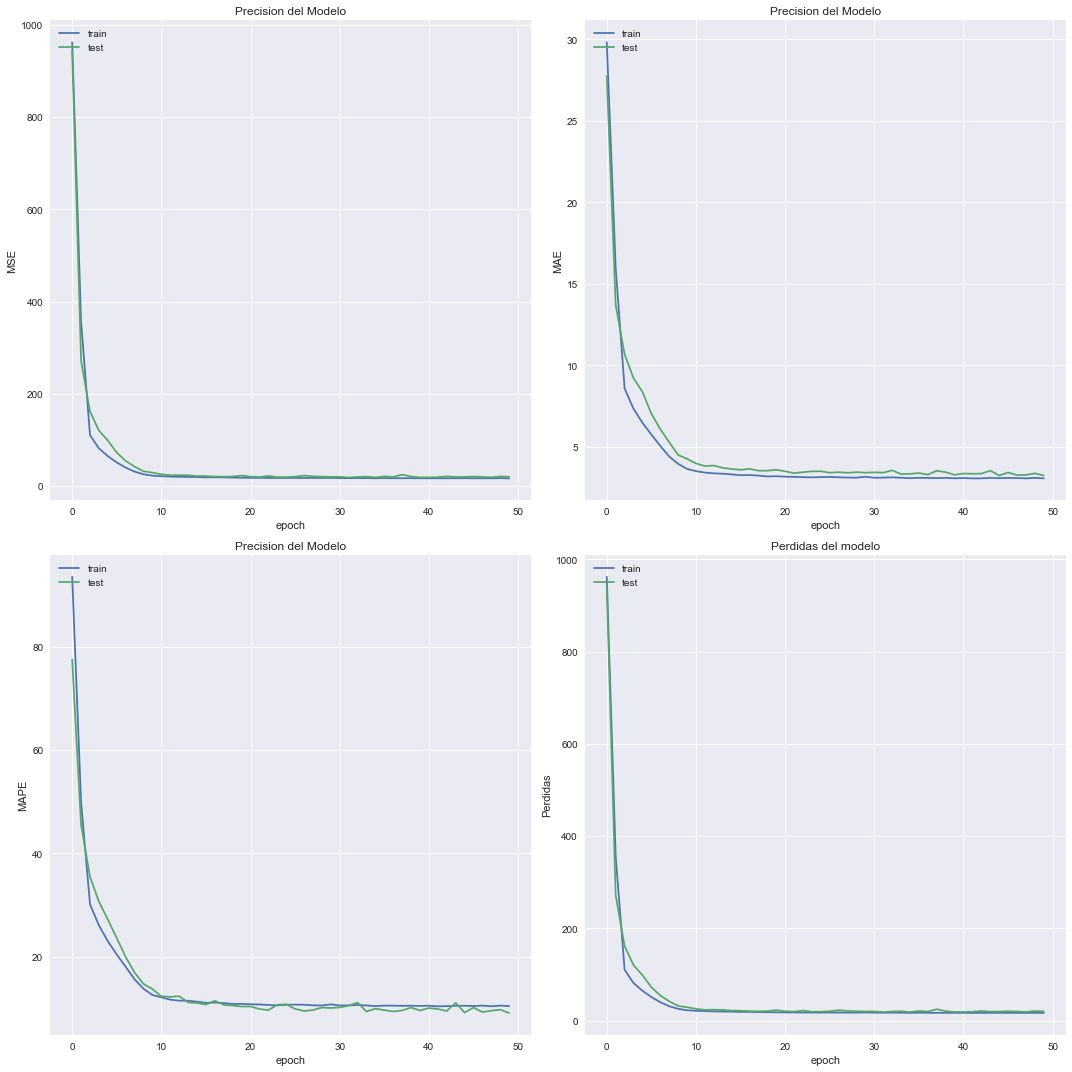

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(15,15))


# Resumen de 'mean_squared_error'
ax1.plot(history.history['mean_squared_error'])
ax1.plot(history.history['val_mean_squared_error'])
ax1.set_title('Precision del Modelo')
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
#plt.show()

# Resumen de 'mean_absolute_error'
ax2.plot(history.history['mean_absolute_error'])
ax2.plot(history.history['val_mean_absolute_error'])
ax2.set_title('Precision del Modelo')
ax2.set_ylabel('MAE')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
#plt.show()

# Resumen de 'mean_absolute_percentage_error'
ax3.plot(history.history['mean_absolute_percentage_error'])
ax3.plot(history.history['val_mean_absolute_percentage_error'])
ax3.set_title('Precision del Modelo')
ax3.set_ylabel('MAPE')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'test'], loc='upper left')
#plt.show()

# Resumen de la funcion de perdida definida
ax4.plot(history.history['loss'])
ax4.plot(history.history['val_loss'])
ax4.set_title('Perdidas del modelo')
ax4.set_ylabel('Perdidas')
ax4.set_xlabel('epoch')
ax4.legend(['train', 'test'], loc='upper left')
fig.tight_layout()

plt.show()

### Predicción

In [13]:
Y_pred = model.predict(X_test_rs)

# mostramos las predicciones para cada tramo
for i in range(len(X_test_rs)):
        print("X=%s, Predicted=%s" % (X_test_rs[i], Y_pred[i]))


X=[ 0.25714489 -0.0769386   0.82277664], Predicted=[38.31255]
X=[0.64781872 0.28254402 0.80350986], Predicted=[35.641327]
X=[ 0.22555235 -0.01484517  0.80201047], Predicted=[37.144535]
X=[0.541515   0.42746421 0.80212652], Predicted=[33.05392]
X=[-0.05691165 -0.40249868  0.79537379], Predicted=[40.14489]
X=[0.68282941 0.36252936 0.79183148], Predicted=[34.661488]
X=[0.85434302 1.4321235  0.80055773], Predicted=[21.306345]
X=[ 0.06343911 -0.08945163  0.81152478], Predicted=[37.007908]
X=[0.70225643 0.49921879 0.57486762], Predicted=[31.829062]
X=[0.90940836 2.0733809  0.59375538], Predicted=[14.671442]
X=[-0.81875801 -1.36924939 -0.11980379], Predicted=[44.78259]
X=[0.68697232 0.37119447 0.07247586], Predicted=[32.306953]
X=[-0.27600338 -1.02348971  0.047886  ], Predicted=[43.79708]
X=[0.56170838 0.89255926 0.32440441], Predicted=[25.385382]
X=[ 0.95394534  2.82419947 -0.04674106], Predicted=[13.25713]
X=[-0.30308715 -1.00733963  0.32555289], Predicted=[44.298683]
X=[0.62316582 1.309998

In [14]:
#Creamos el dataframe de validación
test_val = pd.DataFrame(X_test)
test_val.columns = (["pwr","porc","viento_aparente"])
test_val["spd"] = Y_test
test_val["Y_pred"] = Y_pred
test_val["diff"] = test_val["spd"]-test_val["Y_pred"]
test_val.head()

,pwr,porc,viento_aparente,spd,Y_pred,diff
0,196.808012,-0.399565,14.918299,39.688230,38.312550,1.375680
1,230.996299,0.523132,14.577416,32.568368,35.641327,-3.072959
2,194.043315,-0.240187,14.550887,36.984000,37.144535,-0.160535
3,221.693546,0.895103,14.552940,31.571813,33.053921,-1.482107
4,169.324586,-1.235191,14.433466,41.239149,40.144890,1.094259


(array([ 1.,  1.,  3.,  6.,  8., 10., 17.,  7.,  2.,  6.,  5.,  5.,  1.,
         2.,  3.,  0.,  0.,  0.,  1.,  1.]),
 array([-7.87267098, -6.67251982, -5.47236867, -4.27221751, -3.07206636,
        -1.87191521, -0.67176405,  0.5283871 ,  1.72853826,  2.92868941,
         4.12884057,  5.32899172,  6.52914287,  7.72929403,  8.92944518,
        10.12959634, 11.32974749, 12.52989865, 13.7300498 , 14.93020095,
        16.13035211]),
 <a list of 20 Patch objects>)

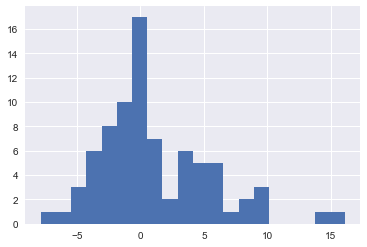

In [21]:
#Ploteamos las diferencias entre las velocidades reales y las predichas por el modelo
plt.hist(test_val['diff'], bins=20)

In [16]:
#Mostramos los valores significativos de las predicciones y la diferencia con los reales

print("Predicciones:")
print(test_val["Y_pred"].mean())
print(test_val["Y_pred"].max())
print(test_val["Y_pred"].min())

print("Diferencias:")
print(test_val["diff"].mean())
print(test_val["diff"].max())
print(test_val["diff"].min())

Predicciones:
32.5548095703125
55.20025
13.25713
Diferencias:
1.1438524718962113
16.130352109178254
-7.872670976505724


#### Comprobaciones finales del resultado

In [18]:
#Añadimos al df de validación los datos de origen (distancia y tiempo)
#Y cálculamos el tiempo según la predicción de la velocidad obtenida

test_val['dist'] = df_test['dist']
test_val['time_seg'] = df_test['time_seg']
test_val['time_seg_pred'] = test_val['dist']/(test_val['Y_pred']/3.6)

In [19]:
tiempo_real = test_val['time_seg'].sum()
tiempo_pred = test_val['time_seg_pred'].sum()
print('Tiempo Real: %s' %str(datetime.timedelta(seconds=int(tiempo_real))))
print('Tiempo Predicho: %s' %str(datetime.timedelta(seconds=tiempo_pred)))

Tiempo Real: 3:08:13
Tiempo Predicho: 3:09:04.991803


#### Mostramos los datos con mayor diferencia para analizar


Analizando los datos, puede observarse que la mayoría de estos datos provienen de cambios de pendiente bruscos

Por ejemplo. Si acabamos de coronar un puerto, normalmente los primeros metros se usan para descansar y la velocidad es menor de lo esperado

Otro ejemplo. En una zona de toboganes, podemos afrontar una pendiente con una alta velocidad y 'falsear' el resultado

Por otro lado, vemos que 5 de los 7 registros, son pendientes de bajada. El trazado de curvas también puede afectar

La predicción está hecha sobre una competición real (Ironman 70.3 Marbella) y se aprecia como la velocidad bajando en competición es mayor que en entrenamientos, debido al tráfico cerrado y la actitud del competidor

Una posible mejora sería añadir como input de la red la velocidad incial del tramo

In [23]:
#Analizamos las mayores diferencias según el histograma anterior
test_val[(test_val["diff"]>8) | (test_val["diff"]<-10)]


,pwr,porc,viento_aparente,spd,Y_pred,diff,dist,time_seg,time_seg_pred
22,43.281740,-4.173012,14.445208,61.576779,45.446426,16.130352,3249.885532,190,257.436920
25,245.479461,1.437892,14.238703,40.524726,31.574488,8.950239,630.384632,56,71.873999
41,209.982609,0.511746,-11.610435,38.214585,29.231459,8.983127,329.070042,31,40.526615
46,29.602529,-6.597866,14.398382,69.830249,55.200249,14.630000,2754.415368,142,179.634973
56,79.446017,-4.068272,14.193814,55.784874,47.403862,8.381012,1580.571429,102,120.033616
76,98.781851,-3.050762,-14.134608,47.753510,38.341187,9.412323,848.951282,64,79.711269
92,37.767373,-5.245116,-6.017731,55.405954,46.978100,8.427855,8788.000000,571,673.437167


### Exportamos el Modelo para ser usado en el Simulador

In [24]:
pickle.dump(scalarX, open("Scaler.model", 'wb'))


model.save("TF_Tramos_2.model")
#Para cargar el modelo
#https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model